We are goint to work in the competition: House Prices - Advanced Regression Techniques ( https://www.kaggle.com/c/house-prices-advanced-regression-techniques )


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g6sqNe1G-tvsf0rBp4WzUa88lKECBQMeNFKZ-LTC6iWQKfDVGO8-sY
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns
from scipy.stats import skew
from numpy import mean, std
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [ ]:
# Import dataset
train = pd.read_csv("/content/drive/MyDrive/Ignacio Fiori Training/Machine Learning/HousePrices/train.csv")

**Exploration and Preprocessing of Data**

The first thing to do is to split our dataset.

In [ ]:
train.shape

(1460, 81)

As we can see, we have 1460 rows with 81 features. Our goal is to predict the column name SalePrice. Besides, as we don't have so many rows, we'll split the dataset only in train and test datasets.

In [ ]:
train, test=train_test_split(train, test_size=.2)

In [ ]:
print(train.shape)
print(test.shape)

(1168, 81)
(292, 81)


In [ ]:
# Visualize some elements of the dataset to see how it looks
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
920,921,60,RL,70.0,8462,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,6,5,1994,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,105.0,Gd,Gd,PConc,Gd,Gd,No,GLQ,814,Unf,0,114,928,GasA,...,Y,SBrkr,936,785,0,1721,0,1,2,1,3,1,Gd,7,Typ,0,NaN,Attchd,1994.0,RFn,2,471,TA,TA,Y,300,87,0,0,0,0,NaN,NaN,NaN,0,7,2007,WD,Normal,201000
985,986,190,RL,68.0,10880,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,2fmCon,1Story,5,5,1950,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1040,Unf,0,124,1164,GasW,...,N,SBrkr,1164,0,0,1164,1,0,1,0,3,1,TA,5,Typ,0,NaN,Detchd,1950.0,Unf,1,240,TA,TA,Y,0,48,0,0,0,0,NaN,NaN,NaN,0,8,2008,ConLD,Normal,125000
169,170,20,RL,NaN,16669,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,1Story,8,6,1981,1981,Hip,WdShake,Plywood,Plywood,BrkFace,653.0,Gd,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1686,1686,GasA,...,Y,SBrkr,1707,0,0,1707,0,0,2,1,2,1,TA,6,Typ,1,TA,Attchd,1981.0,RFn,2,511,TA,TA,Y,574,64,0,0,0,0,NaN,NaN,NaN,0,1,2006,WD,Normal,228000
266,267,60,RL,70.0,11207,Pave,NaN,IR1,HLS,AllPub,FR2,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,714,Unf,0,88,802,GasA,...,Y,SBrkr,802,709,0,1511,1,0,2,1,3,1,TA,8,Typ,1,TA,Attchd,1997.0,Fin,2,413,TA,TA,Y,95,75,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,185000
649,650,180,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SFoyer,4,6,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,131,GLQ,499,0,630,GasA,...,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,TA,3,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,12,2007,WD,Normal,84500


In just a few rows we can see that we have NaN values, later we'll have to deal with them

In [ ]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [ ]:
quantitative = [feature for feature in train.columns if train.dtypes[feature] != 'object']
qualitative = [feature for feature in train.columns if train.dtypes[feature] == 'object']

We have a lot of categorial variables. We have to see how to deal with them


**Correlation Analysis**

Let see the most correlated features.



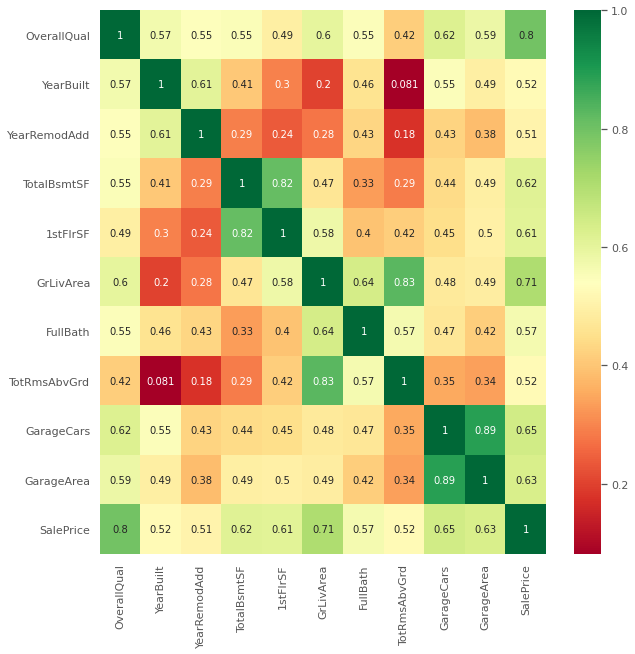

In [ ]:
# most correlated features
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")




*   From this we can tell which features (OverallQual, GrLivArea and TotalBsmtSF ) are highly positively correlated with the SalePrice.
*   Garage Cars and Garage Are also seems correlated between them since the numbers of car that will fit into the garage will depend on Garage Area.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


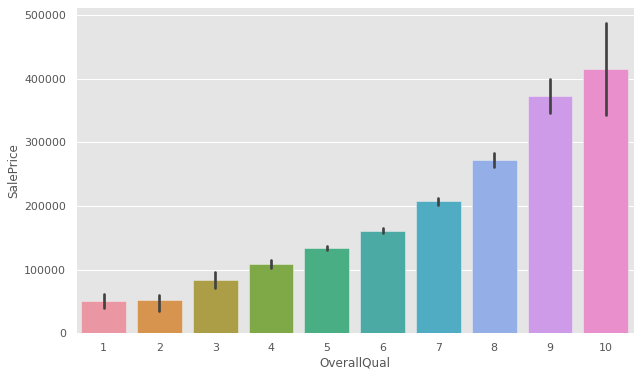

In [ ]:
sns.barplot(train.OverallQual,train.SalePrice)

We can see in this graph how when the rate of the OverallQual increases, the price also increases

Scatter plots between 'SalePrice' and correlated variables



/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


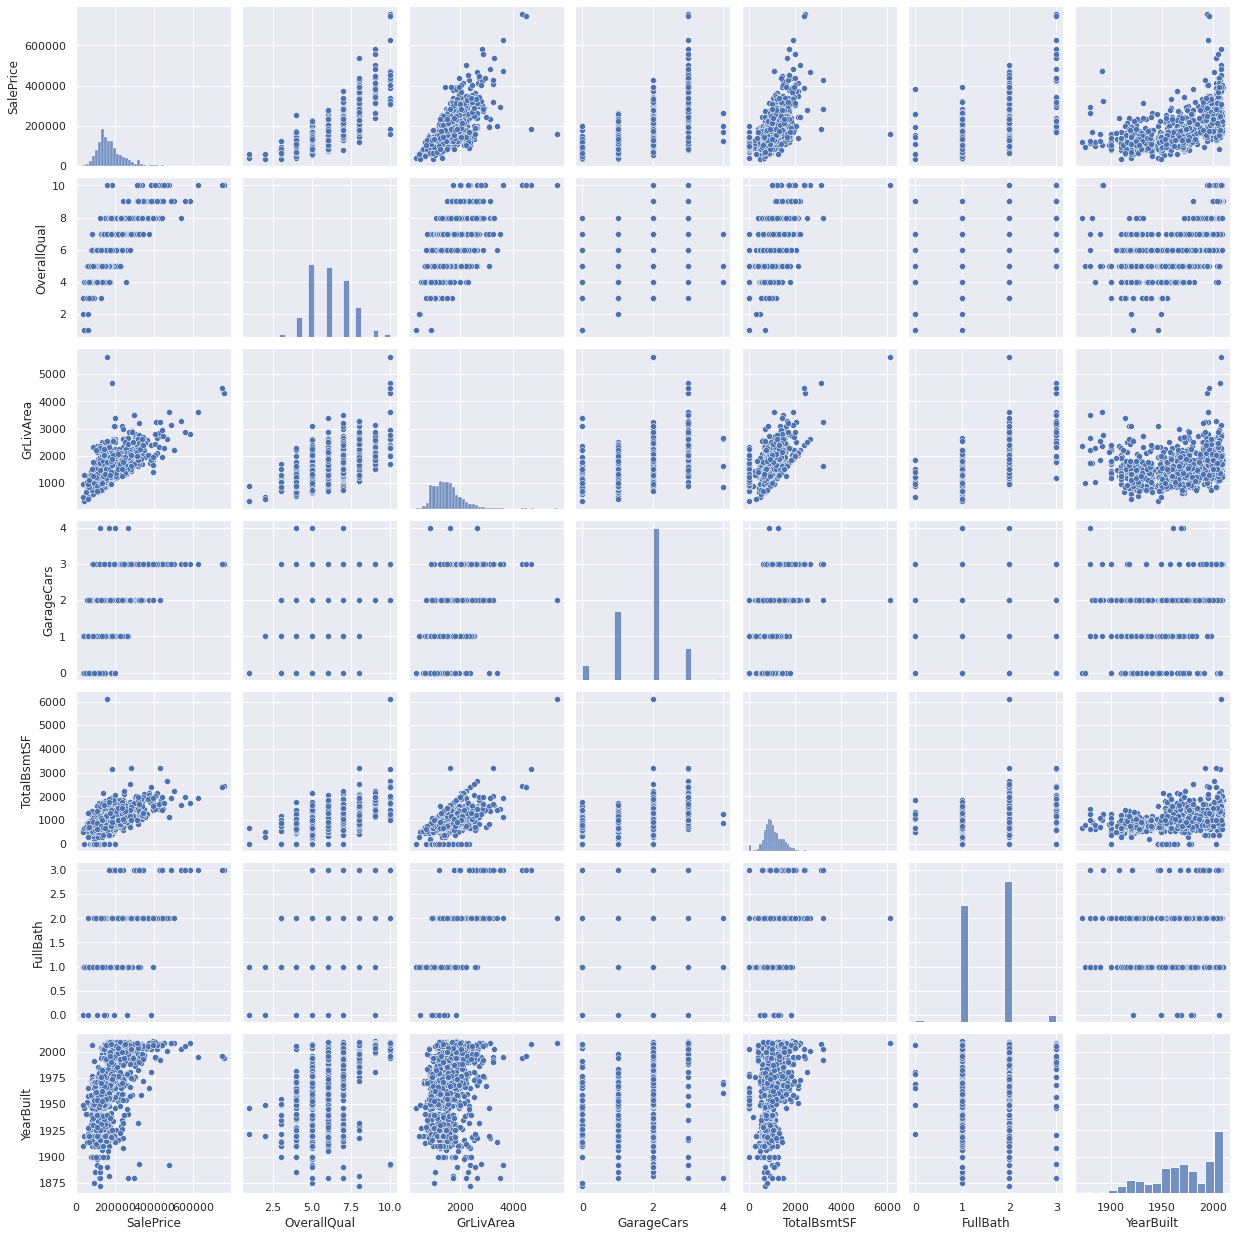

In [ ]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

GrLiv Area and TotalBsmtSF seem to have linear relationship with SalePrice

**Feature Engineering**

In [ ]:
#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

In [ ]:
#Look at the variable to predict
train.SalePrice.describe()

count      1168.000000
mean     181429.449486
std       81838.333885
min       34900.000000
25%      129000.000000
50%      163000.000000
75%      214925.000000
max      755000.000000
Name: SalePrice, dtype: float64

**Skewness of target feature**

Skew is:  1.9048704433610604


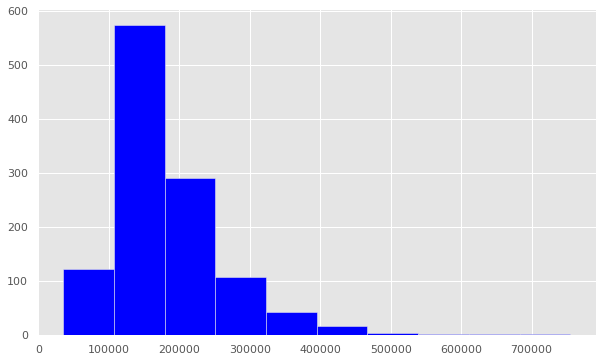

In [ ]:
print("Skew is: ", train.SalePrice.skew())
plt.style.use(style="ggplot")
plt.rcParams["figure.figsize"]=(10,6)
plt.hist(train.SalePrice,color="blue")
plt.show()

Our variable to predict is skewed so we apply the logarithm. The logarithm reduces the dynamic range of a variable so the differences are preserved while the scale is not that dramatically skewed.

In [ ]:
train["SalePrice"] = np.log1p(train["SalePrice"])
test["SalePrice"] = np.log1p(test["SalePrice"])

In [ ]:
# Visualize all the features that have missing values
test_missing = test.isna().sum() / test.shape[0]
test_missing[test_missing > 0.0].sort_values(ascending=False)

PoolQC          1.000000
MiscFeature     0.972603
Alley           0.938356
Fence           0.815068
FireplaceQu     0.503425
LotFrontage     0.171233
GarageYrBlt     0.034247
GarageType      0.034247
GarageFinish    0.034247
GarageQual      0.034247
GarageCond      0.034247
BsmtFinType2    0.023973
BsmtFinType1    0.023973
BsmtExposure    0.023973
BsmtCond        0.023973
BsmtQual        0.023973
MasVnrArea      0.003425
MasVnrType      0.003425
Electrical      0.003425
dtype: float64

In [ ]:
# Visualize all the features that have missing values
train_missing = train.isna().sum() / train.shape[0]
train_missing[train_missing > 0.0].sort_values(ascending=False)

PoolQC          0.994007
MiscFeature     0.960616
Alley           0.937500
Fence           0.805651
FireplaceQu     0.464897
LotFrontage     0.178938
GarageYrBlt     0.060788
GarageType      0.060788
GarageFinish    0.060788
GarageQual      0.060788
GarageCond      0.060788
BsmtExposure    0.026541
BsmtFinType2    0.026541
BsmtFinType1    0.025685
BsmtCond        0.025685
BsmtQual        0.025685
MasVnrArea      0.005993
MasVnrType      0.005993
dtype: float64

We have four features wih more than 0.8 percent of NaN. GarageType, GarageFinish, GarageQual, GarageCond and GarageYrBlt have the same percentage of null values.

Let's start to deal with these NaN values

In [ ]:
#NaN in Pool Quality means No Pool so replace these values by 'None'
train["PoolQC"] = train["PoolQC"].fillna("None")
test["PoolQC"] = test["PoolQC"].fillna("None")

In [ ]:
# MiscFeature : Data documentation says NA means "no misc feature"
train["MiscFeature"] = train["MiscFeature"].fillna("None")
test["MiscFeature"] = test["MiscFeature"].fillna("None")

In [ ]:
#Alley : data description says NA means "no alley access"
train["Alley"] = train["Alley"].fillna("None")
test["Alley"] = test["Alley"].fillna("None")

In [ ]:
#Fence : data description says NA means "no fence"
train["Fence"] = train["Fence"].fillna("None")
test["Fence"] = test["Fence"].fillna("None")

In [ ]:
#FireplaceQu : data description says NA means "no fireplace"
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")
test["FireplaceQu"] = test["FireplaceQu"].fillna("None")

For LotFrontage we will fill the NA with the mean value of the feature

In [ ]:
train_mean = train["LotFrontage"].mean()
train["LotFrontage"] = train["LotFrontage"].fillna(train_mean)
test["LotFrontage"] = test["LotFrontage"].fillna(train_mean)

For all the features related to Garage the NA means No Garage so we will put None

In [ ]:
train["GarageType"] = train["GarageType"].fillna("None")
train["GarageFinish"] = train["GarageFinish"].fillna("None")
train["GarageQual"] = train["GarageQual"].fillna("None")
train["GarageCond"] = train["GarageCond"].fillna("None")
test["GarageType"] = test["GarageType"].fillna("None")
test["GarageFinish"] = test["GarageFinish"].fillna("None")
test["GarageQual"] = test["GarageQual"].fillna("None")
test["GarageCond"] = test["GarageCond"].fillna("None")

As NA means No Garage we will put 0 in GarageYrBlt as there isn't any garage built and the NA for the features related to Garage are in the same rows.

In [ ]:
train["GarageYrBlt"] = train["GarageYrBlt"].fillna("0")
test["GarageYrBlt"] = test["GarageYrBlt"].fillna("0")

For all the features related to Bsmt NA means No Basement so we will put None in these values

In [ ]:
train["BsmtFinType2"] = train["BsmtFinType2"].fillna("None")
train["BsmtExposure"] = train["BsmtExposure"].fillna("None")
train["BsmtQual"] = train["BsmtQual"].fillna("None")
train["BsmtFinType1"] = train["BsmtFinType1"].fillna("None")
train["BsmtCond"] = train["BsmtCond"].fillna("None")

test["BsmtFinType2"] = test["BsmtFinType2"].fillna("None")
test["BsmtExposure"] = test["BsmtExposure"].fillna("None")
test["BsmtQual"] = test["BsmtQual"].fillna("None")
test["BsmtFinType1"] = test["BsmtFinType1"].fillna("None")
test["BsmtCond"] = test["BsmtCond"].fillna("None")

For these two features as it's not clear that NA means no masonry veener we will replace the NA values by the values that appear most for the categorical feature MasVnrType and by the mean for MasVnrArea.

In [ ]:
train_MVT_mode = train["MasVnrType"].mode()[0]
train_MVA_mean = train["MasVnrArea"].mean()

train["MasVnrType"] = train["MasVnrType"].fillna(train_MVT_mode)
train["MasVnrArea"] = train["MasVnrArea"].fillna(train_MVA_mean)

test["MasVnrType"] = test["MasVnrType"].fillna(train_MVT_mode)
test["MasVnrArea"] = test["MasVnrArea"].fillna(train_MVA_mean)


For Electrical we will replace the NA with the most frequent value also


In [ ]:
train_electrical_mode = train["Electrical"].mode()[0]
train["Electrical"] = train["Electrical"].fillna(train_electrical_mode)
test["Electrical"] = test["Electrical"].fillna(train_electrical_mode)


In [ ]:
# Visualize all the features that have missing values
train_missing = train.isna().sum() / train.shape[0]
train_missing[train_missing > 0.0].sort_values(ascending=False)

Series([], dtype: float64)

In [ ]:
# Visualize all the features that have missing values
test_missing = test.isna().sum() / test.shape[0]
test_missing[test_missing > 0.0].sort_values(ascending=False)

Series([], dtype: float64)

In [ ]:
train.shape

(1168, 80)

In [ ]:
test.shape

(292, 80)

In [ ]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1187,20,RL,89.000000,12461,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,1Story,8,5,1994,1995,Gable,CompShg,ImStucc,ImStucc,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,1456,Unf,0,168,1624,GasA,Ex,Y,SBrkr,1624,0,0,1624,1,0,2,0,2,1,Gd,5,Typ,1,Fa,Attchd,1994,RFn,3,757,TA,TA,Y,0,114,192,0,0,0,None,GdPrv,None,0,7,2006,WD,Normal,12.476104
1277,80,RL,70.133607,17871,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,NWAmes,Norm,Norm,1Fam,SLvl,6,5,1967,1976,Gable,CompShg,HdBoard,HdBoard,BrkFace,359.0,TA,TA,CBlock,Gd,TA,Av,ALQ,528,Unf,0,1152,1680,GasA,Fa,Y,SBrkr,1724,0,0,1724,1,0,1,1,3,1,TA,7,Typ,1,Gd,Attchd,1967,RFn,2,480,TA,TA,Y,0,0,0,0,0,0,None,None,None,0,6,2009,WD,Normal,12.195522
1400,50,RM,50.000000,6000,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Norm,Norm,1Fam,1.5Fin,6,7,1929,1950,Gable,CompShg,WdShing,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,862,862,GasA,TA,Y,SBrkr,950,208,0,1158,0,0,1,0,3,1,TA,5,Typ,1,Gd,BuiltIn,1929,RFn,1,208,TA,TA,Y,0,0,112,0,0,0,None,None,None,0,7,2008,WD,Normal,11.695255
32,20,RL,85.000000,11049,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2007,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Ex,TA,Av,Unf,0,Unf,0,1234,1234,GasA,Ex,Y,SBrkr,1234,0,0,1234,0,0,2,0,3,1,Gd,7,Typ,0,None,Attchd,2007,RFn,2,484,TA,TA,Y,0,30,0,0,0,0,None,None,None,0,1,2008,WD,Normal,12.100162
1396,20,RL,70.133607,57200,Pave,None,IR1,Bnk,AllPub,Inside,Sev,Timber,Norm,Norm,1Fam,1Story,5,5,1948,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,Av,BLQ,353,Rec,334,60,747,GasA,TA,Y,SBrkr,1687,0,0,1687,1,0,1,0,3,1,TA,7,Min1,2,TA,Detchd,1966,Unf,2,572,TA,TA,N,0,0,50,0,0,0,None,None,None,0,6,2010,WD,Normal,11.982935


**Outliers**

An outlier is a data point that differs significantly from other observations

In [ ]:
# Select numeric features to visualize outliers
numeric_features=train.select_dtypes(include=[np.number])
for (columnName, _) in numeric_features.iteritems(): 
    print('Column Name: ' + columnName) 

Column Name: MSSubClass
Column Name: LotFrontage
Column Name: LotArea
Column Name: OverallQual
Column Name: OverallCond
Column Name: YearBuilt
Column Name: YearRemodAdd
Column Name: MasVnrArea
Column Name: BsmtFinSF1
Column Name: BsmtFinSF2
Column Name: BsmtUnfSF
Column Name: TotalBsmtSF
Column Name: 1stFlrSF
Column Name: 2ndFlrSF
Column Name: LowQualFinSF
Column Name: GrLivArea
Column Name: BsmtFullBath
Column Name: BsmtHalfBath
Column Name: FullBath
Column Name: HalfBath
Column Name: BedroomAbvGr
Column Name: KitchenAbvGr
Column Name: TotRmsAbvGrd
Column Name: Fireplaces
Column Name: GarageCars
Column Name: GarageArea
Column Name: WoodDeckSF
Column Name: OpenPorchSF
Column Name: EnclosedPorch
Column Name: 3SsnPorch
Column Name: ScreenPorch
Column Name: PoolArea
Column Name: MiscVal
Column Name: MoSold
Column Name: YrSold
Column Name: SalePrice


In [ ]:
# Based on the empirical rule we're going to print the quantity of outliers 
# by feature
for (columnName, columnData) in numeric_features.iteritems(): 
    data_mean, data_std = mean(columnData), std(columnData)
    print("Column name: " + columnName)
    
    # use the empirical rule
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off

    # identify outliers
    outliers = [x for x in columnData if x < lower or x > upper]
    print("Identified outliers", len(outliers))

    # non outliers
    non_outliers = [x for x in columnData if x >= lower and x <= upper]
    print("Non-outlier observations", len(non_outliers))

Column name: MSSubClass
Identified outliers 26
Non-outlier observations 1142
Column name: LotFrontage
Identified outliers 14
Non-outlier observations 1154
Column name: LotArea
Identified outliers 12
Non-outlier observations 1156
Column name: OverallQual
Identified outliers 1
Non-outlier observations 1167
Column name: OverallCond
Identified outliers 23
Non-outlier observations 1145
Column name: YearBuilt
Identified outliers 2
Non-outlier observations 1166
Column name: YearRemodAdd
Identified outliers 0
Non-outlier observations 1168
Column name: MasVnrArea
Identified outliers 24
Non-outlier observations 1144
Column name: BsmtFinSF1
Identified outliers 6
Non-outlier observations 1162
Column name: BsmtFinSF2
Identified outliers 38
Non-outlier observations 1130
Column name: BsmtUnfSF
Identified outliers 11
Non-outlier observations 1157
Column name: TotalBsmtSF
Identified outliers 8
Non-outlier observations 1160
Column name: 1stFlrSF
Identified outliers 12
Non-outlier observations 1156
Colum

By this way we're going to delete many entries so we should try another mechanism or visualize some features in plots in order to visualize the data. We'll plot some features to see how they look but this is a job that can take much time if we want to visualize and understand each numerical feature. Another thing that it's possible to try is the method LocalOutlierFactor provided by sklearn.

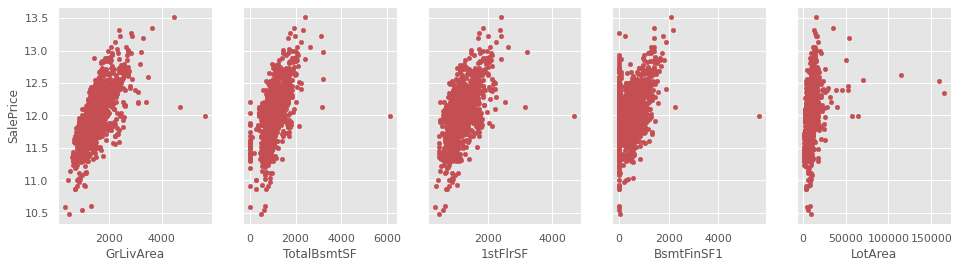

In [ ]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(16, 4))
axes = np.ravel(axes)
col_name = ['GrLivArea','TotalBsmtSF','1stFlrSF','BsmtFinSF1','LotArea']
for i, c in zip(range(5), col_name):
    train.plot.scatter(ax=axes[i], x=c, y='SalePrice', sharey=True, colorbar=False, c='r')


In [ ]:
qualitative

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [ ]:
nominal = ['MSZoning', 'Street', 'Alley', 'Utilities', 'LotConfig', 
              'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 
              'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
              'Foundation', 'Heating', 'CentralAir', 'Electrical', 'Functional', 
              'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']
ordinal = ['LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
            'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 
            'PavedDrive', 'PoolQC', 'Fence']

From categorical variables we have some that are ordinals and some that are nominal. For ordinal variables we'll use target encoding and for nominal we'll use one hot encoding

In [ ]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
920,60,RL,70.000000,8462,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,2Story,6,5,1994,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,105.0,Gd,Gd,PConc,Gd,Gd,No,GLQ,814,Unf,0,114,928,GasA,Ex,Y,SBrkr,936,785,0,1721,0,1,2,1,3,1,Gd,7,Typ,0,None,Attchd,1994,RFn,2,471,TA,TA,Y,300,87,0,0,0,0,None,None,None,0,7,2007,WD,Normal,12.211065
985,190,RL,68.000000,10880,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,2fmCon,1Story,5,5,1950,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1040,Unf,0,124,1164,GasW,TA,N,SBrkr,1164,0,0,1164,1,0,1,0,3,1,TA,5,Typ,0,None,Detchd,1950,Unf,1,240,TA,TA,Y,0,48,0,0,0,0,None,None,None,0,8,2008,ConLD,Normal,11.736077
169,20,RL,70.291971,16669,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Timber,Norm,Norm,1Fam,1Story,8,6,1981,1981,Hip,WdShake,Plywood,Plywood,BrkFace,653.0,Gd,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1686,1686,GasA,TA,Y,SBrkr,1707,0,0,1707,0,0,2,1,2,1,TA,6,Typ,1,TA,Attchd,1981,RFn,2,511,TA,TA,Y,574,64,0,0,0,0,None,None,None,0,1,2006,WD,Normal,12.337105
266,60,RL,70.000000,11207,Pave,None,IR1,HLS,AllPub,FR2,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,Av,GLQ,714,Unf,0,88,802,GasA,Gd,Y,SBrkr,802,709,0,1511,1,0,2,1,3,1,TA,8,Typ,1,TA,Attchd,1997,Fin,2,413,TA,TA,Y,95,75,0,0,0,0,None,None,None,0,6,2006,WD,Normal,12.128117
649,180,RM,21.000000,1936,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SFoyer,4,6,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,131,GLQ,499,0,630,GasA,Gd,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,TA,3,Typ,0,None,None,0,None,0,0,None,None,Y,0,0,0,0,0,0,None,MnPrv,None,0,12,2007,WD,Normal,11.344519


In [ ]:
for var in ordinal:
  mean_encode = train.groupby(var)['SalePrice'].mean()
  train.loc[:, var] = train[var].map(mean_encode)
  test.loc[:, var] = test[var].map(mean_encode)

In [ ]:
train.shape

(1168, 80)

In [ ]:
test.shape

(292, 80)

In [ ]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
920,60,RL,70.000000,8462,Pave,None,12.172885,12.018607,AllPub,Inside,12.017757,SawyerW,Norm,Norm,1Fam,2Story,6,5,1994,1994,Gable,CompShg,HdBoard,HdBoard,BrkFace,105.0,12.316908,11.963426,PConc,12.179621,12.191762,11.948073,12.305029,814,12.041001,0,114,928,GasA,12.214632,Y,SBrkr,936,785,0,1721,0,1,2,1,3,1,12.231045,7,Typ,0,11.795515,Attchd,1994,12.171111,2,471,12.071570,12.074529,12.062766,300,87,0,0,0,0,12.02036,12.060685,None,0,7,2007,WD,Normal,12.211065
985,190,RL,68.000000,10880,Pave,None,11.926668,12.018607,AllPub,Inside,12.017757,Edwards,Norm,Norm,2fmCon,1Story,5,5,1950,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,11.832111,12.041872,CBlock,11.803494,12.043050,11.948073,11.951031,1040,12.041001,0,124,1164,GasW,11.808294,N,SBrkr,1164,0,0,1164,1,0,1,0,3,1,11.804718,5,Typ,0,11.795515,Detchd,1950,11.813801,1,240,12.071570,12.074529,12.062766,0,48,0,0,0,0,12.02036,12.060685,None,0,8,2008,ConLD,Normal,11.736077
169,20,RL,70.291971,16669,Pave,None,12.172885,12.018607,AllPub,Corner,12.017757,Timber,Norm,Norm,1Fam,1Story,8,6,1981,1981,Hip,WdShake,Plywood,Plywood,BrkFace,653.0,12.316908,12.041872,CBlock,12.179621,12.043050,11.948073,11.962611,0,12.041001,0,1686,1686,GasA,11.808294,Y,SBrkr,1707,0,0,1707,0,0,2,1,2,1,11.804718,6,Typ,1,12.195167,Attchd,1981,12.171111,2,511,12.071570,12.074529,12.062766,574,64,0,0,0,0,12.02036,12.060685,None,0,1,2006,WD,Normal,12.337105
266,60,RL,70.000000,11207,Pave,None,12.172885,12.271779,AllPub,FR2,12.017757,Gilbert,Norm,Norm,1Fam,2Story,6,5,1997,1997,Gable,CompShg,VinylSd,VinylSd,None,0.0,11.832111,12.041872,PConc,12.179621,12.043050,12.159590,12.305029,714,12.041001,0,88,802,GasA,11.903172,Y,SBrkr,802,709,0,1511,1,0,2,1,3,1,11.804718,8,Typ,1,12.195167,Attchd,1997,12.341473,2,413,12.071570,12.074529,12.062766,95,75,0,0,0,0,12.02036,12.060685,None,0,6,2006,WD,Normal,12.128117
649,180,RM,21.000000,1936,Pave,None,11.926668,12.018607,AllPub,Inside,12.017757,MeadowV,Norm,Norm,Twnhs,SFoyer,4,6,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,11.832111,12.041872,CBlock,12.179621,12.043050,12.159590,11.861985,131,12.095240,499,0,630,GasA,11.903172,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,11.804718,3,Typ,0,11.795515,None,0,11.494322,0,0,11.494322,11.494322,12.062766,0,0,0,0,0,0,12.02036,11.823810,None,0,12,2007,WD,Normal,11.344519


In [ ]:
test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1205,20,RL,90.000000,14684,Pave,None,12.172885,12.018607,AllPub,CulDSac,12.017757,SawyerW,Norm,Norm,1Fam,1Story,7,7,1990,1991,Hip,CompShg,HdBoard,HdBoard,BrkFace,234.0,12.316908,12.041872,CBlock,12.179621,12.04305,12.083711,11.951031,485,11.851376,177,1496,2158,GasA,11.903172,Y,SBrkr,2196,0,0,2196,0,0,2,0,3,1,12.231045,7,Typ,1,12.195167,Attchd,1990,12.171111,3,701,12.07157,12.074529,12.062766,84,70,0,0,0,0,12.02036,12.060685,None,0,6,2009,WD,Normal,12.513193
939,70,RL,70.291971,24090,Pave,None,11.926668,12.018607,AllPub,Inside,12.017757,ClearCr,Norm,Norm,1Fam,2Story,7,7,1940,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,11.832111,11.963426,CBlock,11.803494,12.04305,12.083711,11.962611,0,12.041001,0,1032,1032,GasA,12.214632,Y,SBrkr,1207,1196,0,2403,0,0,2,0,4,1,11.804718,10,Typ,2,12.195167,Attchd,1940,11.813801,1,349,12.07157,12.074529,12.062766,56,0,318,0,0,0,12.02036,12.060685,None,0,6,2010,COD,Normal,12.406566
571,20,RL,60.000000,7332,Pave,None,11.926668,12.018607,AllPub,Inside,12.017757,NAmes,Norm,Norm,1Fam,1Story,6,6,1959,1959,Gable,CompShg,WdShing,Wd Shng,BrkFace,207.0,11.832111,12.041872,CBlock,11.803494,12.04305,11.948073,11.861985,414,12.041001,0,450,864,GasA,12.214632,Y,SBrkr,864,0,0,864,1,0,1,0,2,1,12.231045,4,Typ,0,11.795515,Attchd,1959,11.813801,1,288,12.07157,12.074529,12.062766,168,0,0,0,0,0,12.02036,12.060685,None,0,10,2006,WD,Abnorml,11.695255
1091,160,FV,24.000000,2160,Pave,Pave,11.926668,12.018607,AllPub,Inside,12.017757,Somerst,Norm,Norm,Twnhs,2Story,7,5,1999,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,212.0,12.316908,12.041872,PConc,12.179621,12.04305,11.948073,11.861985,510,12.041001,0,90,600,GasA,12.214632,Y,SBrkr,624,628,0,1252,1,0,2,1,2,1,12.231045,4,Typ,0,11.795515,Detchd,1999,11.813801,2,462,12.07157,12.074529,12.062766,0,48,0,0,0,0,12.02036,12.060685,None,0,3,2008,WD,Normal,11.982935
803,60,RL,107.000000,13891,Pave,None,11.926668,12.018607,AllPub,Inside,12.017757,NridgHt,Norm,Norm,1Fam,2Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,424.0,12.778362,12.041872,PConc,12.635765,12.04305,12.379661,11.962611,0,12.041001,0,1734,1734,GasA,12.214632,Y,SBrkr,1734,1088,0,2822,0,0,3,1,4,1,12.622497,12,Typ,1,12.260689,BuiltIn,2009,12.171111,3,1020,12.07157,12.074529,12.062766,52,170,0,0,192,0,12.02036,12.060685,None,0,1,2009,New,Partial,13.275829


In [ ]:
# With the drop first delete redundant
train = pd.get_dummies(train, drop_first=True)

In [ ]:
train.shape

(1168, 299)

In [ ]:
test = pd.get_dummies(test, drop_first=True)

In [ ]:
test.shape

(292, 238)

In [ ]:
train.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,...,GarageYrBlt_1989.0,GarageYrBlt_1990.0,GarageYrBlt_1991.0,GarageYrBlt_1992.0,GarageYrBlt_1993.0,GarageYrBlt_1994.0,GarageYrBlt_1995.0,GarageYrBlt_1996.0,GarageYrBlt_1997.0,GarageYrBlt_1998.0,GarageYrBlt_1999.0,GarageYrBlt_2000.0,GarageYrBlt_2001.0,GarageYrBlt_2002.0,GarageYrBlt_2003.0,GarageYrBlt_2004.0,GarageYrBlt_2005.0,GarageYrBlt_2006.0,GarageYrBlt_2007.0,GarageYrBlt_2008.0,GarageYrBlt_2009.0,GarageYrBlt_2010.0,GarageYrBlt_0,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
920,60,70.000000,8462,12.172885,12.018607,12.017757,6,5,1994,1994,105.0,12.316908,11.963426,12.179621,12.191762,11.948073,12.305029,814,12.041001,0,114,928,12.214632,936,785,0,1721,0,1,2,1,3,1,12.231045,7,0,11.795515,12.171111,2,471,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
985,190,68.000000,10880,11.926668,12.018607,12.017757,5,5,1950,1950,0.0,11.832111,12.041872,11.803494,12.043050,11.948073,11.951031,1040,12.041001,0,124,1164,11.808294,1164,0,0,1164,1,0,1,0,3,1,11.804718,5,0,11.795515,11.813801,1,240,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
169,20,70.291971,16669,12.172885,12.018607,12.017757,8,6,1981,1981,653.0,12.316908,12.041872,12.179621,12.043050,11.948073,11.962611,0,12.041001,0,1686,1686,11.808294,1707,0,0,1707,0,0,2,1,2,1,11.804718,6,1,12.195167,12.171111,2,511,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
266,60,70.000000,11207,12.172885,12.271779,12.017757,6,5,1997,1997,0.0,11.832111,12.041872,12.179621,12.043050,12.159590,12.305029,714,12.041001,0,88,802,11.903172,802,709,0,1511,1,0,2,1,3,1,11.804718,8,1,12.195167,12.341473,2,413,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
649,180,21.000000,1936,11.926668,12.018607,12.017757,4,6,1970,1970,0.0,11.832111,12.041872,12.179621,12.043050,12.159590,11.861985,131,12.095240,499,0,630,11.903172,630,0,0,630,1,0,1,0,1,1,11.804718,3,0,11.795515,11.494322,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [ ]:
test.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageCars,GarageArea,...,GarageYrBlt_1981.0,GarageYrBlt_1982.0,GarageYrBlt_1983.0,GarageYrBlt_1984.0,GarageYrBlt_1986.0,GarageYrBlt_1987.0,GarageYrBlt_1988.0,GarageYrBlt_1989.0,GarageYrBlt_1990.0,GarageYrBlt_1991.0,GarageYrBlt_1992.0,GarageYrBlt_1993.0,GarageYrBlt_1994.0,GarageYrBlt_1995.0,GarageYrBlt_1996.0,GarageYrBlt_1997.0,GarageYrBlt_1998.0,GarageYrBlt_1999.0,GarageYrBlt_2000.0,GarageYrBlt_2001.0,GarageYrBlt_2002.0,GarageYrBlt_2003.0,GarageYrBlt_2004.0,GarageYrBlt_2005.0,GarageYrBlt_2006.0,GarageYrBlt_2007.0,GarageYrBlt_2008.0,GarageYrBlt_2009.0,GarageYrBlt_2010.0,GarageYrBlt_0,MiscFeature_Shed,SaleType_CWD,SaleType_ConLD,SaleType_ConLw,SaleType_New,SaleType_WD,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1205,20,90.000000,14684,12.172885,12.018607,12.017757,7,7,1990,1991,234.0,12.316908,12.041872,12.179621,12.04305,12.083711,11.951031,485,11.851376,177,1496,2158,11.903172,2196,0,0,2196,0,0,2,0,3,1,12.231045,7,1,12.195167,12.171111,3,701,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
939,70,70.291971,24090,11.926668,12.018607,12.017757,7,7,1940,1950,0.0,11.832111,11.963426,11.803494,12.04305,12.083711,11.962611,0,12.041001,0,1032,1032,12.214632,1207,1196,0,2403,0,0,2,0,4,1,11.804718,10,2,12.195167,11.813801,1,349,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
571,20,60.000000,7332,11.926668,12.018607,12.017757,6,6,1959,1959,207.0,11.832111,12.041872,11.803494,12.04305,11.948073,11.861985,414,12.041001,0,450,864,12.214632,864,0,0,864,1,0,1,0,2,1,12.231045,4,0,11.795515,11.813801,1,288,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1091,160,24.000000,2160,11.926668,12.018607,12.017757,7,5,1999,2000,212.0,12.316908,12.041872,12.179621,12.04305,11.948073,11.861985,510,12.041001,0,90,600,12.214632,624,628,0,1252,1,0,2,1,2,1,12.231045,4,0,11.795515,11.813801,2,462,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
803,60,107.000000,13891,11.926668,12.018607,12.017757,9,5,2008,2009,424.0,12.778362,12.041872,12.635765,12.04305,12.379661,11.962611,0,12.041001,0,1734,1734,12.214632,1734,1088,0,2822,0,0,3,1,4,1,12.622497,12,1,12.260689,12.171111,3,1020,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


As we can see, train and test datasets are of different size so we will use inner join to leave them with the same size

In [ ]:
train, test = train.align(test, join='inner', axis=1)

In [ ]:
train.shape


(1168, 236)

In [ ]:
test.shape

(292, 236)

In [ ]:
# Visualize all the features that have missing values
test_missing = test.isna().sum() / test.shape[0]
test_missing[test_missing > 0.0].sort_values(ascending=False)

Series([], dtype: float64)

In [ ]:
y_train=train['SalePrice']
X_train=train.drop(["SalePrice"], axis=1)
y_test=test['SalePrice']
X_test=test.drop(["SalePrice"], axis=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 235)
(292, 235)
(1168,)
(292,)


**Models**

**Linear Regression**

In [ ]:
lr=linear_model.LinearRegression()
lr.fit(X_train,y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))


MSE train: 0.012167246710065928
RMSE train: 0.11030524334802008
MSE test: 0.016241513149483598
RMSE test: 0.1274421953258951


**Random Forest**

In [ ]:
rfc = RandomForestRegressor()
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))

MSE train: 0.003011777857579017
RMSE train: 0.05487966706876981
MSE test: 0.015578910735111931
RMSE test: 0.1248155067894688


Here we tested the RF alghoritm with a set of parameters of example and his performance is better than with Linear Regression taking into account the RMSE error.

In [ ]:
feature_list = list(train.columns)

# Get numerical feature importances
importances = list(rfc.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances if (pair[1] > 0.0)];


Variable: OverallQual          Importance: 0.53
Variable: GrLivArea            Importance: 0.13
Variable: TotalBsmtSF          Importance: 0.04
Variable: GarageCars           Importance: 0.04
Variable: GarageArea           Importance: 0.03
Variable: YearBuilt            Importance: 0.02
Variable: BsmtFinSF1           Importance: 0.02
Variable: 1stFlrSF             Importance: 0.02
Variable: LotFrontage          Importance: 0.01
Variable: LotArea              Importance: 0.01
Variable: OverallCond          Importance: 0.01
Variable: YearRemodAdd         Importance: 0.01
Variable: ExterQual            Importance: 0.01
Variable: BsmtUnfSF            Importance: 0.01
Variable: 2ndFlrSF             Importance: 0.01
Variable: GarageFinish         Importance: 0.01
Variable: Heating_Wall         Importance: 0.01


These features seems to be the ones with importance in the prediction of Random Forest. We'll make a new set of train and train the model in order to see if the performance improves.

In [ ]:
new_train = train[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1',
                   'GarageArea', 'YearBuilt', '1stFlrSF', 'GarageCars', 
                   'Heating_Wall', 'LotFrontage', 'LotArea', 'OverallCond',
                   'YearRemodAdd', 'BsmtUnfSF', 'FireplaceQu', 
                   'GarageFinish', 'ExterQual', '2ndFlrSF', 'SalePrice']]
                   
new_test = test[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'BsmtFinSF1',
                   'GarageArea', 'YearBuilt', '1stFlrSF', 'GarageCars', 
                   'Heating_Wall', 'LotFrontage', 'LotArea', 'OverallCond',
                   'YearRemodAdd', 'BsmtUnfSF', 'FireplaceQu', 
                   'GarageFinish', 'ExterQual', '2ndFlrSF', 'SalePrice']]

In [ ]:
new_train.shape

(1168, 19)

In [ ]:
new_test.shape

(292, 19)

In [ ]:
y_train=new_train['SalePrice']
X_train=new_train.drop(["SalePrice"], axis=1)
y_test=new_test['SalePrice']
X_test=new_test.drop(["SalePrice"], axis=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1168, 18)
(292, 18)
(1168,)
(292,)


In [ ]:
rfc = RandomForestRegressor()
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)

mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)
print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)
print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))

MSE train: 0.003128601676002311
RMSE train: 0.05593390453027851
MSE test: 0.015022826049559594
RMSE test: 0.122567638671713


In [ ]:
# Create the parameter grid
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [50, 60, 70],
    'max_features': ['auto','sqrt'],
    'min_samples_leaf': [1, 3],
    'min_samples_split': [10, 12],
    'n_estimators': [400, 500, 600]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)
grid_search.best_params_


Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  9.3min finished


{'bootstrap': False,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 400}

In [ ]:
rfc = RandomForestRegressor(n_estimators = 400, bootstrap = False, max_depth = 70, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 10)
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)
mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))

MSE train: 0.002869850523274739
RMSE train: 0.05357098583444903
MSE test: 0.013778093438197312
RMSE test: 0.1173801236930568


**Gradient Boosting**

In [ ]:
grad_boost = GradientBoostingRegressor()
grad_boost.fit(X_train, y_train)
y_pred_train = grad_boost.predict(X_train)
y_pred_test = grad_boost.predict(X_test)
mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))

MSE train: 0.007911481812971468
RMSE train: 0.08894651096570043
MSE test: 0.014878168395224682
RMSE test: 0.12197609763894188


In [ ]:
# Create the parameter grid
param_grid={'n_estimators':[100,400,700,1000], 
            'learning_rate': [0.05,0.1,0.3],
            'max_depth':[3,6,9,12] }
# Create a based model
grad_boost = GradientBoostingRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = grad_boost, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)
grid_search.best_params_


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  2.4min finished


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [ ]:
grad_boost = GradientBoostingRegressor(n_estimators = 100, 
                                       max_depth = 3, learning_rate = 0.1)
grad_boost.fit(X_train, y_train)
y_pred_train = grad_boost.predict(X_train)
y_pred_test = grad_boost.predict(X_test)
mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))

MSE train: 0.007911481812971468
RMSE train: 0.08894651096570043
MSE test: 0.014944449566023393
RMSE test: 0.12224749308686618


Let's use one example to predict real values of the target variable

In [ ]:
rfc = RandomForestRegressor(n_estimators = 400, bootstrap = False, max_depth = 70, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 10)
rfc.fit(X_train, y_train)
y_pred_train = rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)
mse_train = mean_squared_error(y_train,y_pred_train)
rmse_train = sqrt(mse_train)

print("MSE train: " + str(mse_train))
print("RMSE train: " + str(rmse_train))

mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = sqrt(mse_test)

print("MSE test: " + str(mse_test))
print("RMSE test: " + str(rmse_test))

MSE train: 0.002867463199878781
RMSE train: 0.05354869932947747
MSE test: 0.013682322538287675
RMSE test: 0.11697146035801928


In [ ]:
y_test=pd.DataFrame({'count':np.exp(y_test)})
y_test.head(20)

,count
1205,271901.0
939,244401.0
571,120001.0
1091,160001.0
803,582934.0
1184,186701.0
124,181001.0
1447,240001.0
959,155001.0
163,103201.0


In [ ]:
y_pred_test=pd.DataFrame({'count':np.exp(y_pred_test)})
y_pred_test.head(20)

,count
0,289668.338792
1,199712.823251
2,119315.446733
3,152595.009268
4,412754.672577
5,175974.185518
6,172692.421963
7,261251.706036
8,166889.371463
9,101974.843787


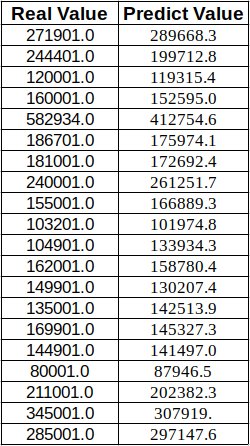

In many values the predicted value is near from the real ones